In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, make_scorer

## Segunda Actividad: Minería de Datos

Esta vez ya tenemos los datos tratados y vamos a analizar qué modelos de minería de datos serían más óptimos, qué métricas deberíamos utilizar y qué podríamos hacer para ir mejorando los modelos propuestos.

En primer lugar, vamos a leer ambos datasets, el normalizado y el sin normalizar.

In [2]:
data = pd.read_csv('hotel_booking_cleaned.csv')
data_normalized = pd.read_csv('hotel_booking_normalized_cleaned.csv')

#### Tipo de problema

El problema es predecir si una reserva va a ser cancelada o no (y = is_canceled). Esto es un problema de clasificación binaria, para el cual necesitaremos un algoritmo de aprendizaje supervisado. Concretamente, a lo largo de este trabajo vamos a probar con Regresión Logística, árboles de decisión, RandomForest y XGBoost.

#### Métrica principal 

Nuestra idea es predecir si una habitación va a ser cancelada o no, con la idea quizás de hacer un control de Overbooking y poner más habitaciones a la venta. Para este estudio, pienso que es muy importante minimizar los errores de tipo I, es decir, minimizar el número de veces que predecimos una habitación cancelada que al final resulta no serlo. Es decir, si predecimos una cancelación, debemos estar bastante seguros de que es cierta. Ya que, si lo utilizamos para controlar el Overbooking, en cada fallo que cometamos, vamos a dejar a personas sin habitación, lo que puede producir una muy mala imagen del hotel y gasto en indemnizaciones. Por ello, vamos a tomar como métrica de referencia en principio la Precisión, que mide el número de aciertos de clase 1 partido el número de clasificaciones totales de clase 1 que hemos hecho.

$$
\text{Precisión} = \frac{TP}{TP + FP}
$$

#### Otras métricas a tener en cuenta

En cada modelo pintaremos la matriz de confusión y el F1 Score, con la idea de entender un poco cómo está evolucionando el equilibrio entre la precisión y el recall también. Pero, como he comentado antes, con la idea principal siempre de minimizar los errores en la clase 1 (precisión).

#### División del dataset

En un primer momento, vamos a ver cómo son nuestras predicciones tomando una división simple de un 80% del dataset para train, y de un 20% para tests.

In [3]:
# Eliminamos columnas innecesarias
columns_to_drop = ['arrival_date_week_number', 'arrival_date_day_of_month', 'year_month'] 
data = data.drop(columns=columns_to_drop)
data_normalized = data_normalized.drop(columns=columns_to_drop)


X = data.drop('is_canceled', axis=1) 
y = data['is_canceled']  

X_normalized = data_normalized.drop('is_canceled', axis=1) 
y_normalized = data_normalized['is_canceled']  

# Dividimos 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=4)

#### Regresión Logística

El primer modelo que vamos a probar es la Regresión Logística. 

Es un algoritmo diseñado especialmente para este tipo de problemas (clasificaciones binarias), debido a que, durante su construcción, parte de una regresión lineal y utiliza la función sigmoide, con la idea de "empujar" las predicciones a los extremos 0 y 1. Además, nos dará valores entre 0 y 1, que pueden ser interpretados como la probabilidad de pertenecer a clase 1, esto puede ser interesante para controlar el umbral (threshold)  a partir del cual clasificamos un dato como 0 o como 1.

Además, para este modelo, vamos a utilizar los datos normalizados, ya que si las variables tienen escalas muy diferentes (por ejemplo, ingresos en cientos y nº de adultos en un rango de 0 a 10), las que tienen valores más grandes pueden tener más influencia en los coeficientes, lo que puede dificultar la convergencia del modelo.

c:\Users\4sell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


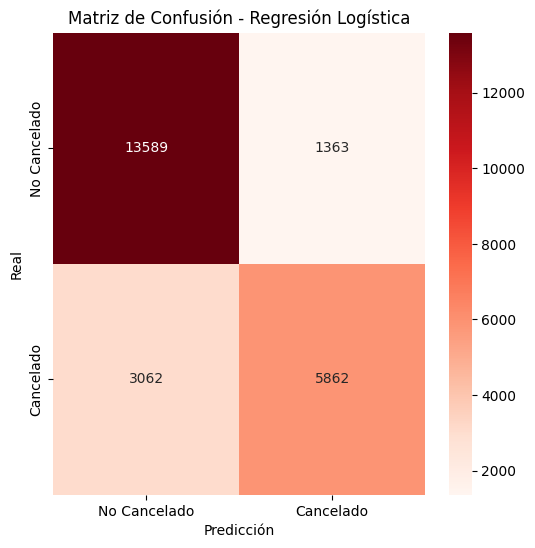

F1 Score: 0.7260
Accuracy: 0.8147
Precision: 0.8113


In [4]:
# 1. Ajustamos el modelo de regresión logística
model = LogisticRegression(random_state=4)
model.fit(X_train_normalized, y_train_normalized)

# 2. Realizamos las predicciones sobre el conjunto de test
y_pred = model.predict(X_test_normalized)

# 3. Matriz de confusión
cm = confusion_matrix(y_test_normalized, y_pred)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['No Cancelado', 'Cancelado'], 
            yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# 4. Métricas
f1 = f1_score(y_test_normalized, y_pred)
accuracy = accuracy_score(y_test_normalized, y_pred)
precision = precision_score(y_test_normalized, y_pred)

# Imprimimos las métricas
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')


Los resultados no son del todo malos. Al predecir una cancelación, acertamos en más de un 80%. 

Ahora, vamos a intentar mejorarlo moviendo el punto de corte (threshold). Partiendo de él, si lo aumentamos, entonces nuestra precisión mejorará, ya que seremos más conservadores a la hora de predecir un 1. Esto, puede resultar interesante para nuestro caso, ya que, como hemos dicho, nuestro objetivo principal será predecir una cancelación estando seguros de no fallar.

Para decidir este punto de corte, veamos primero cómo están siendo las predicciones de nuestro modelo:

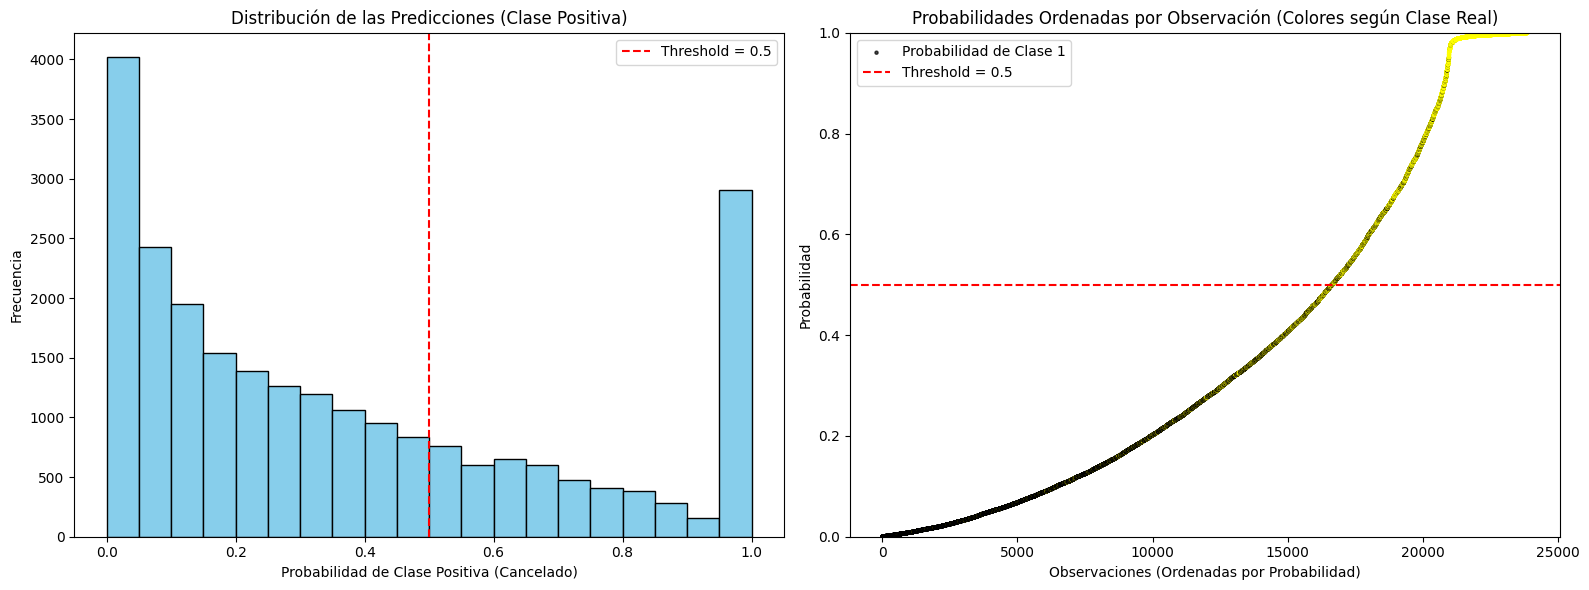

In [5]:
# Obtenemos las probabilidades de la clase positiva (Cancelado)
y_pred_proba_positive = model.predict_proba(X_test_normalized)[:, 1]

# Ordenamos las probabilidades de la clase positiva y asociamos las clases reales
sorted_indices = np.argsort(y_pred_proba_positive)
sorted_positive_probs = y_pred_proba_positive[sorted_indices]
sorted_real_classes = y_test_normalized.iloc[sorted_indices]  # Asegúrate de que y_test_normalized esté indexado correctamente

# Creamos colores: azul para clase 1, rojo para clase 0
colors = ['yellow' if cls == 1 else 'black' for cls in sorted_real_classes]

# Creamos la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Histograma de probabilidades
axes[0].hist(y_pred_proba_positive, bins=20, color='skyblue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')  # Línea del umbral
axes[0].set_title('Distribución de las Predicciones (Clase Positiva)')
axes[0].set_xlabel('Probabilidad de Clase Positiva (Cancelado)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Subplot 2: Scatter plot de probabilidades ordenadas con colores según clase real
axes[1].scatter(range(len(sorted_positive_probs)), sorted_positive_probs, color=colors, alpha=0.7, s=5, label='Probabilidad de Clase 1')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='Threshold = 0.5')  # Línea del umbral
axes[1].set_title('Probabilidades Ordenadas por Observación (Colores según Clase Real)')
axes[1].set_xlabel('Observaciones (Ordenadas por Probabilidad)')
axes[1].set_ylabel('Probabilidad')
axes[1].set_ylim(0, 1)  # Limitar eje Y entre 0 y 1
axes[1].legend()

# Mostramos los subplots
plt.tight_layout()
plt.show()

En la primera gráfica podemos ver un histograma sobre cómo están distribuidas nuestras probabilidades predichas de pertenecer a clase 1.
Y, en la segunda, podemos ver, en color amarillo las reservas que han sido canceladas, y en color negro las que no lo han sido. Y, en el eje X las tenemos ordenadas por la probabilidad que hemos dado de pertenecer a clase 1, mientras que en el eje y se muestra esta probabilidad. 

Podemos observar a simple vista que el modelo es bastante bueno y predice muy bien las reservas que van a ser canceladas. Jugando un poco "a ojo", podemos ver que entre las probabilidades 0.4 - 0.8 es donde más está fallando (clasifica muchos que deberían ser amarillos como negros y viceversa), y más le cuesta diferenciar.

Por ello, una sencilla solución para aplicar este modelo de una forma óptima, podría ser simplemente tomar un threshold = 0.8. De esta manera, mejoramos nuestro modelo y aumentamos considerablemente nuestra precisión (hasta el 0.9656), y nos aseguramos más acertar al predecir una cancelación. Evidentemente, fallamos más a la hora de predecir una "No cancelación", pero como hemos comentado, esto va a depender de las necesidades del negocio, y en nuestro caso estamos suponiendo que esto no nos importa especialmente.

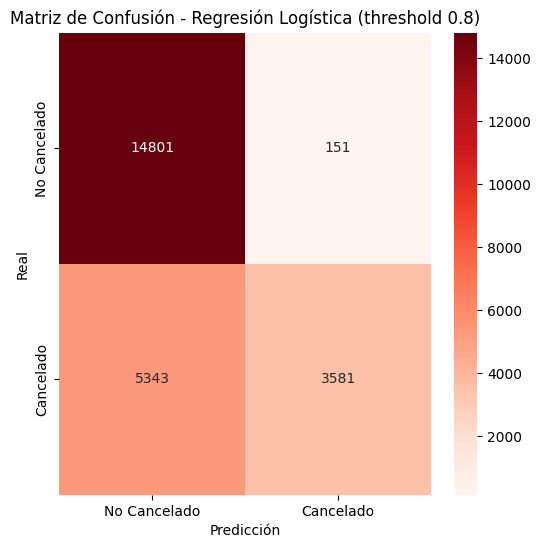

F1 Score (umbral 0.8): 0.5659
Accuracy (umbral 0.8): 0.7699
Precision (umbral 0.8): 0.9595


In [7]:
# Definimos un nuevo umbral
threshold = 0.8 # Cambia el valor según lo desees

# Clasificamos según el nuevo umbral
y_pred_custom = (y_pred_proba_positive >= threshold).astype(int)

# Matriz de confusión
cm_rf = confusion_matrix(y_test_normalized, y_pred_custom)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística (threshold 0.8)')
plt.show()

# Evaluamos las métricas con el nuevo umbral
f1_custom = f1_score(y_test_normalized, y_pred_custom)
accuracy_custom = accuracy_score(y_test_normalized, y_pred_custom)
precision_custom = precision_score(y_test_normalized, y_pred_custom)

# Imprimimos las nuevas métricas
print(f'F1 Score (umbral {threshold}): {f1_custom:.4f}')
print(f'Accuracy (umbral {threshold}): {accuracy_custom:.4f}')
print(f'Precision (umbral {threshold}): {precision_custom:.4f}')

#### Árbol de decisión

Ahora, vamos a probar con un árbol de decisión sencillo, con la idea de ver cómo funcionan las variables de nuestro modelo. Esta vez, no vamos a utilizar los datos escalados, ya que debido a cómo están creados estos modelos, normalizar variables o no realmente no influye en sus resultados.

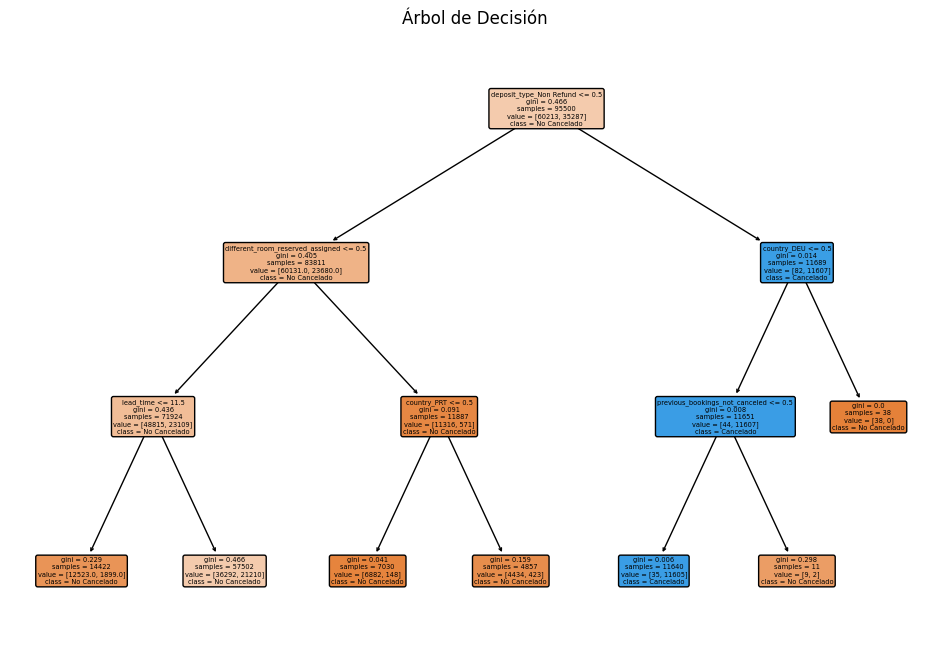

Importancia de las variables:
                             Variable  Importancia
41            deposit_type_Non Refund     0.779129
15   different_room_reserved_assigned     0.114624
0                           lead_time     0.097606
88                        country_DEU     0.005657
180                       country_PRT     0.001885
..                                ...          ...
83                        country_CRI     0.000000
84                        country_CUB     0.000000
85                        country_CYM     0.000000
86                        country_CYP     0.000000
233      arrival_date_month_September     0.000000

[234 rows x 2 columns]


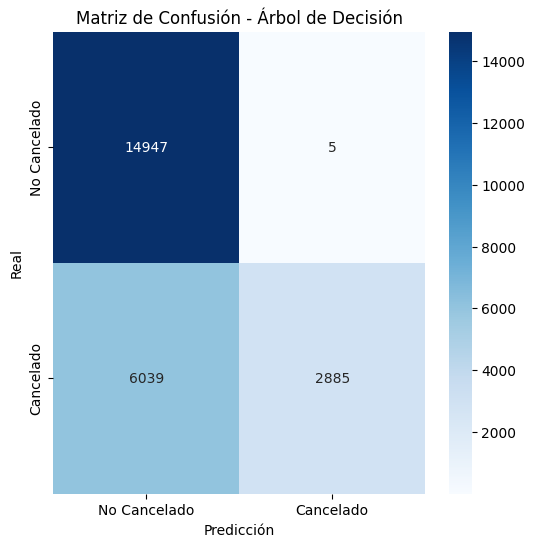

F1 Score: 0.4884
Accuracy: 0.7469
Precision: 0.9983


In [11]:
# Entrenamos un árbol de decisión
clf_tree = DecisionTreeClassifier(max_depth=3, random_state=4)
clf_tree.fit(X_train, y_train)

# Visualizamos el árbol de decisión
plt.figure(figsize=(12, 8))
plot_tree(clf_tree, feature_names=X_train.columns, class_names=['No Cancelado', 'Cancelado'], filled=True, rounded=True)
plt.title('Árbol de Decisión')
plt.show()

# Importancia de las variables
importances = clf_tree.feature_importances_
feature_importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Mostramos las variables más influyentes
print("Importancia de las variables:")
print(feature_importance_df)

# Predicciones y métricas
y_pred_tree = clf_tree.predict(X_test)

# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Métricas de desempeño
f1_tree = f1_score(y_test, y_pred_tree)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)

# Imprimimos las métricas
print(f'F1 Score: {f1_tree:.4f}')
print(f'Accuracy: {accuracy_tree:.4f}')
print(f'Precision: {precision_tree:.4f}')


Podemos ver algo muy interesante. Una de las variables más importantes es "deposit_type_Non Refund" a la hora de clasificar. Esto puede ser debido a que, si una persona aún no ha pagado su reserva o se encuentra en el plazo en el que se le puede devolver el dinero, entonces probablemente sea más propenso a cancelar la reserva, ya que no tiene esa obligación de pagar.

Además, podemos observar que el modelo es muy fiable a la hora de predecir cancelaciones, se equivoca únicamente en 5 clasificaciones de cancelaciones. Sin embargo, también es incluso más conservador que el anterior, debido a que predice como cancelaciones menos de 3000 reservas, con lo cual es lógico que se equivoque menos. Esto hay que tenerlo en cuenta de cara a decidir un modelo.

#### RandomForest

Ahora, con la idea de mejorar nuestros resultados tomando árboles de decisión, vamos a basarnos en la técnica de "bagging", cuya idea principal es combinar múltiples modelos (normalmente débiles) para mejorar la precisión y reducir la varianza del modelo final. Trabajaremos con RandomForest, que es una extensión de bagging que utiliza árboles de decisión como modelos base, pero introduce un paso adicional de aleatorización para reducir la correlación entre los árboles.

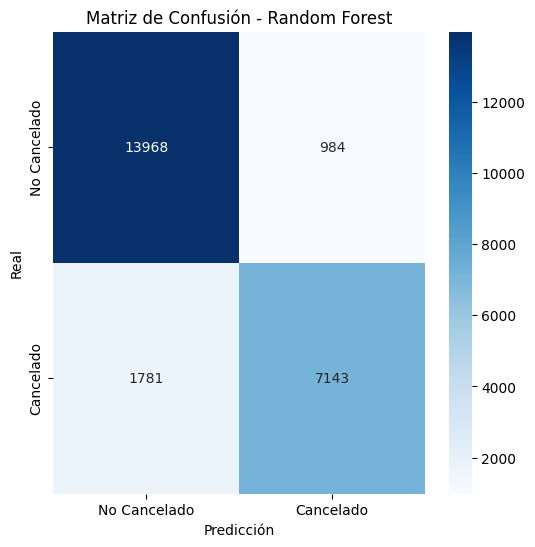

F1 Score (Random Forest): 0.8378
Accuracy (Random Forest): 0.8842
Precision (Random Forest): 0.8789


In [12]:
# 1. Ajustamos el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=4)
rf_model.fit(X_train, y_train)

# 2. Realizamos las predicciones sobre el conjunto de test
y_pred_rf = rf_model.predict(X_test)

# 3. Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# 4. Métricas
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

# Imprimimos las métricas
print(f'F1 Score (Random Forest): {f1_rf:.4f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.4f}')
print(f'Precision (Random Forest): {precision_rf:.4f}')

Esta vez hemos obtenido un modelo menos conservador, cuyas predicciones son muy buenas, superando una precisión del 87%. De cara a elegir el modelo, ya deberíamos pensar en lo que preferimos, si uno muy conservador, que prácticamente nos asegure al 100% que una reserva va a ser cancelada, pero contando con un número bajo de ellas; o si preferimos un modelo más arriesgado, que predice muy bien en general, con el que vamos a acertar muchas reservas canceladas pero también más errores.

#### Optimización de hiperparámetros y Cross-Validation

Vamos ahora a buscar un mejor RandomForest modificando sus hiperparámetros y aplicando Cross-Validation:
- GridSearchCV realiza una búsqueda exhaustiva sobre un espacio de parámetros especificado (en este caso, param_grid), y durante este proceso, divide los datos en varias particiones para evaluar el rendimiento del modelo.
- Vamos a tomar la opción cv=5, lo que significa que se está utilizando una validación cruzada de 5 pliegues. Es decir, divide el conjunto de entrenamiento en 5 subconjuntos y entrena el modelo 5 veces, cada vez con un subconjunto diferente como conjunto de validación y los otros 4 como conjunto de entrenamiento.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


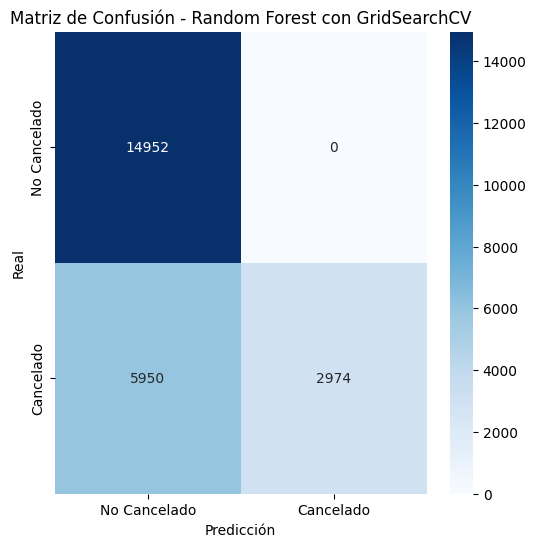

F1 Score (Random Forest): 0.4999
Accuracy (Random Forest): 0.7508
Precision (Random Forest): 1.0000


In [13]:
# 1. Definir el modelo Random Forest
rf_model = RandomForestClassifier(random_state=4)

# 2. Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],  # Número de árboles en el bosque
    'max_depth': [5, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2],    # Número mínimo de muestras en una hoja
    'max_features': ['sqrt', 'log2']  # Número de características a considerar para cada división
}

# 3. Realizar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='precision')
grid_search.fit(X_train, y_train)

# 4. Mostrar los mejores parámetros encontrados
print(f'Best Parameters: {grid_search.best_params_}')

# 5. Obtener el modelo con los mejores parámetros
best_rf_model = grid_search.best_estimator_

# 6. Realizar las predicciones sobre el conjunto de test
y_pred_rf = best_rf_model.predict(X_test)

# 7. Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest con GridSearchCV')
plt.show()

# 8. Métricas
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

# Imprimimos las métricas
print(f'F1 Score (Random Forest): {f1_rf:.4f}')
print(f'Accuracy (Random Forest): {accuracy_rf:.4f}')
print(f'Precision (Random Forest): {precision_rf:.4f}')

Hemos obtenido un modelo muy conservador pero que se ha equivocado en 0 cancelaciones, con lo cual puede resultar de mucha utilidad. Sin embargo, si nos fijamos y lo comparamos con el simple árbol de decisión, que solo tenía 5 errores, ambos tienen predicciones muy similares, y éste último tiene una complejidad muy superior al otro, y es mucho más difícil de interpretar (caja negra).

#### XGBOOST

Finalmente, vamos a probar con un modelo de boosting, concretamente con el más clásico y famoso, el XGBoost. El boosting es una técnica de aprendizaje automático que combina múltiples modelos débiles (por ejemplo, árboles de decisión simples) para formar un modelo más robusto y preciso. Y, su idea principal es entrenar los modelos débiles de forma secuencial, donde cada modelo intenta corregir los errores del modelo anterior.

En primer lugar, vamos a probar con uno sencillo, y después, del mismo modo que con el RandomForest, intentaremos mejorarlo mediante la validación cruzada y la búsqueda de hiperparámetros más óptimos. 

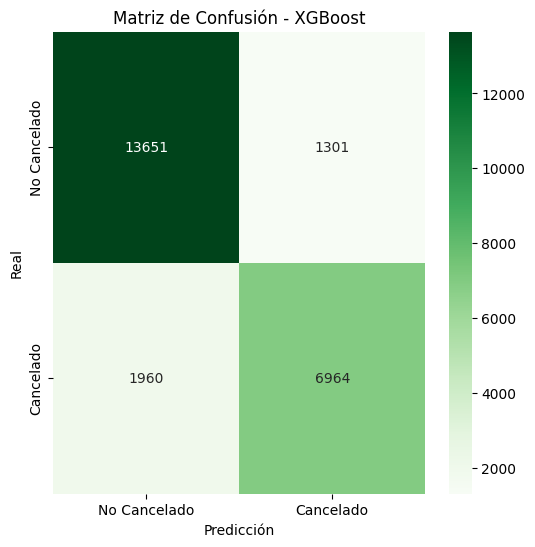

F1 Score (XGBoost): 0.8103
Accuracy (XGBoost): 0.8634
Precision (XGBoost): 0.8426


In [4]:
# 1. Ajustamos el modelo de XGBoost
xgb_model = XGBClassifier(random_state=4, use_label_encoder=False, eval_metric='logloss')  # use_label_encoder=False para evitar warnings
xgb_model.fit(X_train, y_train)

# 2. Realizamos las predicciones sobre el conjunto de test
y_pred_xgb = xgb_model.predict(X_test)

# 3. Matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# 4. Métricas
f1_xgb = f1_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)

# Imprimimos las métricas
print(f'F1 Score (XGBoost): {f1_xgb:.4f}')
print(f'Accuracy (XGBoost): {accuracy_xgb:.4f}')
print(f'Precision (XGBoost): {precision_xgb:.4f}')

Hemos obtenido un modelo bastante bueno, que es capaz de predecir bastante bien las cancelaciones. Pero, sin embargo, si lo comparamos con el RandomForest simple obtenido anteriormente, éste xgboost nos da peores resultados. Vamos a probar con más hiperparámetros y haciendo CV.

#### Optimización de hiperparámetros y Cross-Validation

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


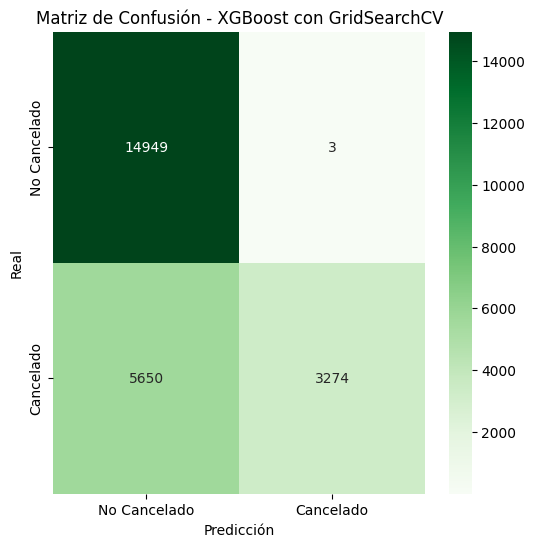

F1 Score (Best XGBoost): 0.5367
Accuracy (Best XGBoost): 0.7632
Precision (Best XGBoost): 0.9991


In [7]:
# Definimos el modelo base
xgb_model = XGBClassifier(random_state=4, use_label_encoder=False, eval_metric='logloss')

# Definimos la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],          # Número de árboles
    'max_depth': [3, 5, 7],                  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2],       # Tasa de aprendizaje
    'subsample': [0.8, 1.0],                 # Fracción de muestras utilizadas para entrenar cada árbol
    'colsample_bytree': [0.8, 1.0],          # Fracción de características utilizadas por árbol
    'gamma': [0, 1, 5],                      # Reducción mínima de la pérdida para hacer una división
}

# Configuramos el GridSearchCV con precision como métrica
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(precision_score, average='binary'),  # Optimiza la precisión de la clase positiva
    cv=3,                      # Número de divisiones para validación cruzada
    verbose=1,                 # Nivel de detalle
    n_jobs=-1                  # Usa todos los núcleos disponibles
)

# Ejecutamos el GridSearchCV
grid_search.fit(X_train, y_train)

# Mostramos los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluamos el mejor modelo
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_best)

# Visualizamos la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['No Cancelado', 'Cancelado'], yticklabels=['No Cancelado', 'Cancelado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost con GridSearchCV')
plt.show()

# Calculamos métricas
f1_best = f1_score(y_test, y_pred_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)

print(f'F1 Score (Best XGBoost): {f1_best:.4f}')
print(f'Accuracy (Best XGBoost): {accuracy_best:.4f}')
print(f'Precision (Best XGBoost): {precision_best:.4f}')


Hemos obtenido un modelo con unas predicciones muy similares al RandomForest de antes. 

#### Elección del modelo

Finalmente, a la hora de seleccionar el modelo, como ya hemos comentado a lo largo del trabajo, va a depender mucho de nuestras necesidades. Pese a que todos los modelos se han construido con la premisa de reducir al mínimo el número de errores tipo I, hemos obtenido modelos más y menos conservadores a la hora de predecir. Yo destacaría 2 principales opciones:

- Opción 1: Por un lado, si queremos ser muy conservadores y asegurarnos de tener una efectividad prácticamente perfecta a la hora de predecir una cancelación, yo personalmente escogería el árbol de decisión simple por encima del último RandomForest y del último XGBoost, ya que es mucho más sencillo de interpretar y los resultados son prácticamente iguales.

- Opción 2: Por otro lado, si buscamos ser un poco más arriesgados y tener una cantidad mayor de reservas predichas como canceladas para ponerlas de nuevo a funcionar en la web (overbooking), yo escogería el primer RandomForest que hemos probado, ya que predice más de 7000 como cancelaciones y se equivoca en un 12% aprox.

Ahora, considerando el supuesto de que somos una cadena hotelera que quiere controlar el overbooking, yo personalmente optaría por un punto de vista conservador, ya que el dejar a una persona sin habitación puede ser muy perjudicial a largo plazo, no solo por la indemnización, sino más por el hecho de tener reseñas negativas. Por ello, optaría por la opción 1.

#### Siguientes pasos

Vamos a proponer una serie de siguientes pasos que podríamos probar con la idea de mejorar la precisión de nuestros modelos. 
- Utilizar cross-validation: En lugar de tomar una división 80-20 simplemente, podría ser interesante realizar CV en todos los modelos para, a la hora de probar modelos, quedarnos con el mejor.
- Intentar mejorar el primer modelo de Regresión Logística mediante regularizaciones L1 o L2.
- Ordenar los individuos según la probabilidad de pertenecer a clase 1 de un modelo, y obtener las métricas por percentiles, para ver cómo evolucionan. Esto podría ser útil de cara a la compañía, con la idea de seleccionar únicamente las reservas con mayor probabilidad de cancelación, y volver a ponerlas a la venta.
- Analizar con SHAP Values las variables más importantes para los últimos modelos (RandomForest y XGBoost).